In [1]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = (128, 32)
BATCH_SIZE = 64
EPOCHS = 20
PADDING_TOKEN = 99

In [3]:
DATA_INPUT_PATH = "dataiam"

images_path = []
labels = []
def preprocess_dataset():
    characters = set()
    max_len = 0

    with open(os.path.join(DATA_INPUT_PATH, 'iam_words', 'words.txt'), 'r') as file:
        lines = file.readlines()
        count = 0
        for line_number, line in enumerate(lines):
            # Skip comments and empty lines
            if line.startswith('#') or line.strip() == '':
                continue

            # Split the line and extract information
            parts = line.strip().split()

            # Continue with the rest of the code
            word_id = parts[0]

            first_folder = word_id.split("-")[0]
            second_folder = first_folder + '-' + word_id.split("-")[1]

            # Construct the image filename
            image_filename = f"{word_id}.png"
            image_path = os.path.join(
                DATA_INPUT_PATH, 'iam_words', 'words', first_folder, second_folder, image_filename)

            # Check if the image file exists
            if os.path.isfile(image_path) and os.path.getsize(image_path):

                images_path.append(image_path)

                # Extract labels
                label = parts[-1].strip()
                for char in label:
                    characters.add(char)

                max_len = max(max_len, len(label))
                labels.append(label)
            count += 1
            if count > 10000:
                break
    
    characters = sorted(list(characters))

    print('characters: ', characters)
    print('max_len: ', max_len)
    # Mapping characters to integers.
    char_to_num = tf.keras.layers.StringLookup(
        vocabulary=list(characters), mask_token=None)

    # Mapping integers back to original characters.
    num_to_char = tf.keras.layers.StringLookup(
        vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
    )
    return characters, char_to_num, num_to_char, max_len
    
characters, char_to_num, num_to_char, max_len = preprocess_dataset()

characters:  ['"', '#', "'", '(', ')', '*', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
max_len:  18


In [4]:
def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

def preprocess_image(image_path, img_size):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image
def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(
        label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]],
                   constant_values=PADDING_TOKEN)
    return label

In [5]:
def process_images_labels(image_path, label):
    image = preprocess_image(image_path, IMAGE_SIZE)
    label = vectorize_label(label)
    return {"image": image, "label": label}

def prepare_dataset(image_paths, labels):
    AUTOTUNE = tf.data.AUTOTUNE
    print('len(image_paths): ', len(image_paths))
    print('len(labels): ', len(labels))
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)

In [6]:
def split_dataset():
    # Split the data into training, validation, and test sets using train_test_split
    train_images, test_images, train_labels, test_labels = train_test_split(
        images_path, labels, test_size=0.2, random_state=42
    )

    # Further split the test set into validation and final test sets
    val_images, test_images, val_labels, test_labels = train_test_split(
        test_images, test_labels, test_size=0.5, random_state=42
    )

    train_set = prepare_dataset(train_images, train_labels)
    val_set = prepare_dataset(val_images, val_labels)
    test_set = prepare_dataset(test_images, test_labels)
    
    return train_set, val_set, test_set

train_set, val_set, test_set = split_dataset()

len(image_paths):  8000
len(labels):  8000
len(image_paths):  1000
len(labels):  1000
len(image_paths):  1000
len(labels):  1000


In [7]:
class CTCLayer(tf.keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * \
            tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * \
            tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred

In [8]:
def build_model():
    input_img = tf.keras.Input(
        shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1), name="image")
    labels = tf.keras.layers.Input(name="label", shape=(None,))

    x = tf.keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
    )(input_img)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
    )(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    new_shape = ((IMAGE_SIZE[0] // 4), (IMAGE_SIZE[1] // 4) * 64)
    x = tf.keras.layers.Reshape(target_shape=new_shape)(x)
    x = tf.keras.layers.Dense(64, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)
    x = tf.keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)
    output = CTCLayer(name="ctc_loss")(labels, x)
    model = tf.keras.models.Model(
        inputs=[input_img, labels], outputs=output
    )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
    model.summary()
    return model
    
model = build_model()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 128, 32,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 32,   │        320 │ image[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 16,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 16,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 8, 64) │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 32, 512)   │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32, 64)    │     32,832 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32, 64)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 32, 256)   │    197,632 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 32, 128)   │    164,352 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense2 (Dense)      │ (None, 32, 77)    │      9,933 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc_loss (CTCLayer) │ (None, 32, 77)    │          0 │ label[0][0],      │
│                     │                   │            │ dense2[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 423,565 (1.62 MB)

 Trainable params: 423,565 (1.62 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
class EditDistanceCallback(tf.keras.callbacks.Callback):
    def __init__(self, pred_model, max_len, validation_images, validation_labels):
        super().__init__()
        self.prediction_model = pred_model
        self.max_len = max_len
        self.validation_images = validation_images
        self.validation_labels = validation_labels

    def calculate_edit_distance(self, labels, predictions, max_len):
        # Get a single batch and convert its labels to sparse tensors.
        saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

        # Make predictions and convert them to sparse tensors.
        input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
        predictions_decoded = tf.keras.backend.ctc_decode(
            predictions, input_length=input_len, greedy=True
        )[0][0][:, :max_len]
        sparse_predictions = tf.cast(
            tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
        )

        # Compute individual edit distances and average them out.
        edit_distances = tf.edit_distance(
            sparse_predictions, saprse_labels, normalize=False
        )
        return tf.reduce_mean(edit_distances)

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(self.validation_images)):
            labels = self.validation_labels[i]
            predictions = self.prediction_model.predict(
                self.validation_images[i])
            edit_distances.append(self.calculate_edit_distance(
                labels, predictions, self.max_len).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )

In [10]:
def train_model():

    validation_images = []
    validation_labels = []

    for batch in val_set:
        validation_images.append(batch["image"])
        validation_labels.append(batch["label"])
    prediction_model = tf.keras.models.Model(
        model.get_layer(name="conv2d").input, model.get_layer(
            name="dense2").output
    )
    edit_distance_callback = EditDistanceCallback(
        prediction_model, max_len, validation_images, validation_labels)
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )
    # Train the model.
    hist = model.fit(
        train_set,
        validation_data=val_set,
        epochs=EPOCHS,
        callbacks=[edit_distance_callback, early_stopping],
    )
    return hist, prediction_model

history, prediction_model = train_model()

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step tep - loss: 34.25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
Mean edit distance for epoch 1: 18.0000
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - loss: 34.0412 - val_loss: 15.8360
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step step - loss: 15.805
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━

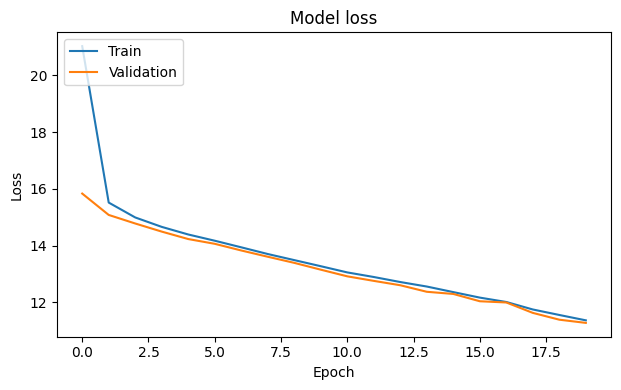

In [11]:
def visualize_train_history(history):
    plt.figure(figsize=(12, 4))

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

visualize_train_history(history)

In [12]:
def evaluate_model():
    accuracy = model.evaluate(test_set)
    print("Test Accuracy:", accuracy)

evaluate_model() 

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 11.6883
Test Accuracy: 11.500542640686035
